# Fit PRDX1 dimer-decamer Kd

This notebook performs analyses described in the 

**Manuscript:**

Modelling the decamerisation cycle of PRDX1 and the inhibition-like effect on its peroxidase activity

**Authors:**

C. Barry, C. Pillay, J.Rohwer

**Purpose:**

Fit Prx decamer Kd to Villar et al. 2022 

Writes: fitted $K_d$ (filename: `fitted_Kd_PRDX1_params.csv`)

**Requirements:**

Python libraries (see **Imports** below)

Prx dimer-decamerisation model (filename: `Prx_dim-dec.psc`)


##### Imports

In [1]:
import os
curdir = os.getcwd()

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from lmfit import Minimizer, minimize, Parameters, Parameter, report_fit
import dill as pickle

import pysces
from identifiability import conf_interval

os.chdir(curdir)

Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
SBML support available
You are using NumPy (1.23.5) with SciPy (1.9.3)
Assimulo CVode available
RateChar is available
Parallel scanner is available

PySCeS environment
******************
pysces.model_dir = /home/chris/Pysces/psc
pysces.output_dir = /home/chris/Pysces


***********************************************************************
* Welcome to PySCeS (1.0.3) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2022  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with this release) for details                *
* Please cite PySCeS with

###### Save directories

In [2]:
prev_dir = os.path.split(os.getcwd())[0]

mod_dir = os.path.join(prev_dir,"models")
if not os.path.isdir(mod_dir): os.mkdir(mod_dir) # ensure dir exists

par_dir = os.path.join(prev_dir,"params")
if not os.path.isdir(par_dir): os.mkdir(par_dir) # ensure dir exists


###### Matplotlib stuff

In [3]:
%matplotlib inline

multiplier = 1
mpl_width = 4.5*multiplier
mpl_height = 3.5*multiplier
mpl_dpi = 600
mpl_xlabel_fontsize = "large"
mpl_ylabel_fontsize = "large"
mu = "\u03bc"

###### Common variables

In [4]:
scan_range = np.logspace(-1,2,100)

In [5]:
# fitting_method = "nelder"
fitting_method = "leastsq"

## Villar et al 2022 fig 5B data

In [6]:
fig_5B_data = np.array([[0.24746, 0.0087789],
                        [0.49398, 0.023144],
                        [0.98609, 0.35834],
                        [1.9869, 0.71588],
                        [4.9168, 0.79569],
                        [9.8149, 0.82283],
                        [19.776, 0.86911],
                        [38.747, 0.93136]])


x_data_exp = fig_5B_data[:,0]
y_data_exp = fig_5B_data[:,1]

## Fit Kd

In [7]:
def scan_onestep_model(mod,x_data_exp):
    mod.dimers_init = 0
    mod.scan_in = "decamers_init"
    mod.scan_out = [f"{i}_ss" for i in mod.species]
    mod.Scan1(x_data_exp/5)
    x_dec = mod.scan["decamers_ss"]/mod.scan["decamers_init"]
    return x_dec

def fit_onestep_Kd(params,mod,x_data_exp,y_data_exp):
    
    mod.Kd_app = params['Kd_app'].value
    mod.kon = mod.koff/mod.Kd_app
#     mod.koff = mod.kon*mod.Kd_app

    # Store k in params
    params['kon'].value = mod.kon
    params["koff"].value = mod.koff
    
    # Scan
    y_data_mod = scan_onestep_model(mod,x_data_exp)
    
    # Calculate residuals
    residuals = np.abs(y_data_exp - y_data_mod)
    
    return residuals

In [8]:
# Load model
mod_Prx_dim_dec = pysces.model("Prx_dim-dec.psc", dir = mod_dir)
mod_Prx_dim_dec.SetQuiet()

# Update 
mod_Prx_dim_dec.exponent = 5

mod_Prx_dim_dec.showModel()

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/Prx_dim-dec.psc
Info: No reagents have been fixed
Info: "Prx_total_dimers" has been initialised but does not occur in a rate equation
Info: "Kd_app" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . . no flux conservation
 done.
 

Fixed species
<none>
 

Reaction stoichiometry and rate equations
disso:
	decamers = {5.00000}dimers
	decamers*koff-pow(dimers,exponent)*kon

Species initial values
decamers_init = 0.0000e+00
dimers_init = 1.0000e+01

Parameters
Prx_total_dimers = 1.0000e+01
koff = 1.0000e+00
kon = 1.0000e+00
Kd_app = 1.1000e+00
exponent = 5.0000e

In [9]:
# Set up lmfit parameter library
param_lib = Parameters() 
param_lib.add('Kd_app', value = 5, vary = True, min =  1e-12)
param_lib.add('kon', value = 1, vary = False, min =  1e-12)
param_lib.add('koff', value = 1, vary = False, min =  1e-12)

# Perform fit
Kd_Minimizer = Minimizer(fit_onestep_Kd, 
                                    param_lib,
                                    fcn_args=(mod_Prx_dim_dec,
                                              x_data_exp,
                                              y_data_exp)
                        )

fit_Kd_to_data = Kd_Minimizer.minimize(method=fitting_method)



[2.22044605e-16]

[2.22044605e-16]

[2.22044605e-16]

[2.22044605e-16]


In [10]:
# Display fit
fit_Kd_to_data

In [11]:
# Scan with fitted parameters
x_dec = scan_onestep_model(mod_Prx_dim_dec,scan_range)


[2.22044605e-16]


/tmp/ipykernel_39002/2291078875.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


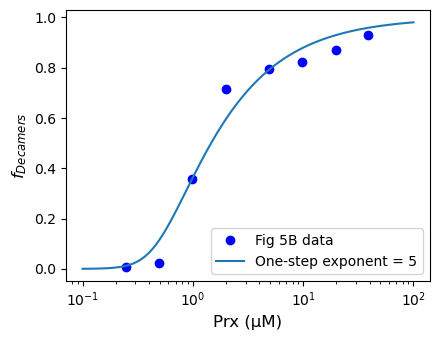

In [12]:
cols = 1
rows = 1
f, axarr = plt.subplots(rows,cols)
f.set_size_inches(w=cols*mpl_width, h=rows*mpl_height)

axarr.semilogx(x_data_exp,y_data_exp,"bo", label = "Fig 5B data")
axarr.semilogx(scan_range,x_dec, label = f"One-step exponent = 5")

axarr.set_ylabel("$f_{Decamers}$",fontsize = mpl_ylabel_fontsize)
axarr.set_xlabel(f"Prx ({mu}M)",fontsize = mpl_xlabel_fontsize)

axarr.legend()
f.tight_layout()
f.show()

## Write to parameter files

In [13]:
# Set up df
data = {"Parameter": ["koff",
                     "kon",
                     "Kd_app"],
        "Value":[fit_Kd_to_data.params["koff"].value,
                fit_Kd_to_data.params["kon"].value,
                fit_Kd_to_data.params["Kd_app"].value]}
df_fitted_params = pd.DataFrame(data)
df_fitted_params.set_index("Parameter",inplace=True)
df_fitted_params

,Value
Parameter,
koff,1.000000
kon,0.700555
Kd_app,1.427439


In [14]:
# Write to file
df_fitted_params.to_csv(os.path.join(curdir,"fitted_Kd_PRDX1_params.csv"), sep=',', encoding='utf-8')
df_fitted_params.to_csv(os.path.join(par_dir,"fitted_Kd_PRDX1_params.csv"), sep=',', encoding='utf-8')
